# Use Off-Policy VPG to Play CartPole-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
torch.manual_seed(0)

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

22:54:44 [INFO] env: <CartPoleEnv<CartPole-v0>>
22:54:44 [INFO] action_space: Discrete(2)
22:54:44 [INFO] observation_space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
22:54:44 [INFO] reward_range: (-inf, inf)
22:54:44 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
22:54:44 [INFO] _max_episode_steps: 200
22:54:44 [INFO] _elapsed_steps: None


In [3]:
class OffPolicyVPGAgent:
    def __init__(self, env,):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        
        self.policy_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[],
                output_size=self.action_n, output_activator=nn.Softmax(1))
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.06)

    def build_net(self, input_size, hidden_sizes, output_size,
            output_activator=None, use_bias=False):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size, bias=use_bias))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        model = nn.Sequential(*layers)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        if self.mode == 'train':
            action = np.random.choice(self.action_n) # use random policy
            self.trajectory += [observation, reward, done, action]
        else:
            state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
            prob_tensor = self.policy_net(state_tensor)
            action_tensor = distributions.Categorical(prob_tensor).sample()
            action = action_tensor.numpy()[0]
        return action

    def close(self):
        if self.mode == 'train':
            self.learn()

    def learn(self):
        state_tensor = torch.as_tensor(self.trajectory[0::4], dtype=torch.float)
        reward_tensor = torch.as_tensor(self.trajectory[1::4], dtype=torch.float)
        action_tensor = torch.as_tensor(self.trajectory[3::4], dtype=torch.long)
        arange_tensor = torch.arange(state_tensor.shape[0], dtype=torch.float)
        discount_tensor = self.gamma ** arange_tensor
        discounted_reward_tensor = discount_tensor * reward_tensor
        discounted_return_tensor = discounted_reward_tensor.flip(0).cumsum(0).flip(0)
        all_pi_tensor = self.policy_net(state_tensor)
        pi_tensor = torch.gather(all_pi_tensor, 1,
                action_tensor.unsqueeze(1)).squeeze(1)
        behavior_prob = 1. / self.action_n
        loss_tensor = -(discounted_return_tensor / behavior_prob * pi_tensor).mean()
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()


agent = OffPolicyVPGAgent(env)

22:54:44 [INFO] ==== train & verify ====
22:54:45 [DEBUG] verify episode 0: reward = 30.00, steps = 30
22:54:45 [DEBUG] verify episode 1: reward = 71.00, steps = 71
22:54:45 [DEBUG] verify episode 2: reward = 42.00, steps = 42
22:54:45 [DEBUG] verify episode 3: reward = 18.00, steps = 18
22:54:45 [DEBUG] verify episode 4: reward = 26.00, steps = 26
22:54:45 [DEBUG] verify episode 5: reward = 19.00, steps = 19
22:54:45 [DEBUG] verify episode 6: reward = 15.00, steps = 15
22:54:45 [DEBUG] verify episode 7: reward = 66.00, steps = 66
22:54:45 [DEBUG] verify episode 8: reward = 21.00, steps = 21
22:54:45 [DEBUG] verify episode 9: reward = 64.00, steps = 64
22:54:45 [DEBUG] verify episode 10: reward = 31.00, steps = 31
22:54:45 [DEBUG] verify episode 11: reward = 38.00, steps = 38
22:54:45 [DEBUG] verify episode 12: reward = 36.00, steps = 36
22:54:45 [DEBUG] verify episode 13: reward = 13.00, steps = 13
22:54:45 [DEBUG] verify episode 14: reward = 21.00, steps = 21
22:54:45 [DEBUG] verify 

22:54:48 [DEBUG] verify episode 129: reward = 54.00, steps = 54
22:54:48 [DEBUG] verify episode 130: reward = 62.00, steps = 62
22:54:48 [DEBUG] verify episode 131: reward = 68.00, steps = 68
22:54:48 [DEBUG] verify episode 132: reward = 84.00, steps = 84
22:54:48 [DEBUG] verify episode 133: reward = 28.00, steps = 28
22:54:48 [DEBUG] verify episode 134: reward = 110.00, steps = 110
22:54:48 [DEBUG] verify episode 135: reward = 47.00, steps = 47
22:54:48 [DEBUG] verify episode 136: reward = 60.00, steps = 60
22:54:48 [DEBUG] verify episode 137: reward = 60.00, steps = 60
22:54:48 [DEBUG] verify episode 138: reward = 64.00, steps = 64
22:54:48 [DEBUG] verify episode 139: reward = 103.00, steps = 103
22:54:48 [DEBUG] verify episode 140: reward = 50.00, steps = 50
22:54:49 [DEBUG] verify episode 141: reward = 116.00, steps = 116
22:54:49 [DEBUG] verify episode 142: reward = 149.00, steps = 149
22:54:49 [DEBUG] verify episode 143: reward = 62.00, steps = 62
22:54:49 [DEBUG] verify episode 

22:54:52 [DEBUG] verify episode 257: reward = 77.00, steps = 77
22:54:53 [DEBUG] verify episode 258: reward = 67.00, steps = 67
22:54:53 [DEBUG] verify episode 259: reward = 64.00, steps = 64
22:54:53 [DEBUG] verify episode 260: reward = 40.00, steps = 40
22:54:53 [DEBUG] verify episode 261: reward = 107.00, steps = 107
22:54:53 [DEBUG] verify episode 262: reward = 51.00, steps = 51
22:54:53 [DEBUG] verify episode 263: reward = 52.00, steps = 52
22:54:53 [DEBUG] verify episode 264: reward = 49.00, steps = 49
22:54:53 [DEBUG] verify episode 265: reward = 49.00, steps = 49
22:54:53 [DEBUG] verify episode 266: reward = 75.00, steps = 75
22:54:53 [DEBUG] verify episode 267: reward = 135.00, steps = 135
22:54:53 [DEBUG] verify episode 268: reward = 43.00, steps = 43
22:54:53 [DEBUG] verify episode 269: reward = 41.00, steps = 41
22:54:53 [DEBUG] verify episode 270: reward = 54.00, steps = 54
22:54:53 [DEBUG] verify episode 271: reward = 76.00, steps = 76
22:54:53 [DEBUG] verify episode 272:

22:54:57 [DEBUG] verify episode 385: reward = 52.00, steps = 52
22:54:57 [DEBUG] verify episode 386: reward = 140.00, steps = 140
22:54:57 [DEBUG] verify episode 387: reward = 108.00, steps = 108
22:54:57 [DEBUG] verify episode 388: reward = 133.00, steps = 133
22:54:57 [DEBUG] verify episode 389: reward = 77.00, steps = 77
22:54:57 [DEBUG] verify episode 390: reward = 48.00, steps = 48
22:54:57 [DEBUG] verify episode 391: reward = 43.00, steps = 43
22:54:57 [DEBUG] verify episode 392: reward = 64.00, steps = 64
22:54:57 [DEBUG] verify episode 393: reward = 66.00, steps = 66
22:54:57 [DEBUG] verify episode 394: reward = 72.00, steps = 72
22:54:57 [DEBUG] verify episode 395: reward = 68.00, steps = 68
22:54:57 [DEBUG] verify episode 396: reward = 56.00, steps = 56
22:54:57 [DEBUG] verify episode 397: reward = 83.00, steps = 83
22:54:57 [DEBUG] verify episode 398: reward = 87.00, steps = 87
22:54:57 [DEBUG] verify episode 399: reward = 81.00, steps = 81
22:54:57 [DEBUG] verify episode 40

22:55:01 [DEBUG] verify episode 513: reward = 78.00, steps = 78
22:55:01 [DEBUG] verify episode 514: reward = 67.00, steps = 67
22:55:01 [DEBUG] verify episode 515: reward = 119.00, steps = 119
22:55:01 [DEBUG] verify episode 516: reward = 51.00, steps = 51
22:55:01 [DEBUG] verify episode 517: reward = 71.00, steps = 71
22:55:02 [DEBUG] verify episode 518: reward = 84.00, steps = 84
22:55:02 [DEBUG] verify episode 519: reward = 51.00, steps = 51
22:55:02 [DEBUG] verify episode 520: reward = 118.00, steps = 118
22:55:02 [DEBUG] verify episode 521: reward = 45.00, steps = 45
22:55:02 [DEBUG] verify episode 522: reward = 62.00, steps = 62
22:55:02 [DEBUG] verify episode 523: reward = 53.00, steps = 53
22:55:02 [DEBUG] verify episode 524: reward = 110.00, steps = 110
22:55:02 [DEBUG] verify episode 525: reward = 39.00, steps = 39
22:55:02 [DEBUG] verify episode 526: reward = 45.00, steps = 45
22:55:02 [DEBUG] verify episode 527: reward = 51.00, steps = 51
22:55:02 [DEBUG] verify episode 52

22:55:06 [DEBUG] verify episode 641: reward = 77.00, steps = 77
22:55:06 [DEBUG] verify episode 642: reward = 79.00, steps = 79
22:55:06 [DEBUG] verify episode 643: reward = 78.00, steps = 78
22:55:06 [DEBUG] verify episode 644: reward = 57.00, steps = 57
22:55:06 [DEBUG] verify episode 645: reward = 50.00, steps = 50
22:55:06 [DEBUG] verify episode 646: reward = 66.00, steps = 66
22:55:06 [DEBUG] verify episode 647: reward = 53.00, steps = 53
22:55:06 [DEBUG] verify episode 648: reward = 58.00, steps = 58
22:55:06 [DEBUG] verify episode 649: reward = 59.00, steps = 59
22:55:06 [DEBUG] verify episode 650: reward = 96.00, steps = 96
22:55:06 [DEBUG] verify episode 651: reward = 65.00, steps = 65
22:55:06 [DEBUG] verify episode 652: reward = 70.00, steps = 70
22:55:06 [DEBUG] verify episode 653: reward = 62.00, steps = 62
22:55:06 [DEBUG] verify episode 654: reward = 86.00, steps = 86
22:55:06 [DEBUG] verify episode 655: reward = 101.00, steps = 101
22:55:07 [DEBUG] verify episode 656: r

22:55:11 [DEBUG] verify episode 769: reward = 109.00, steps = 109
22:55:12 [DEBUG] verify episode 770: reward = 95.00, steps = 95
22:55:12 [DEBUG] verify episode 771: reward = 62.00, steps = 62
22:55:12 [DEBUG] verify episode 772: reward = 74.00, steps = 74
22:55:12 [DEBUG] verify episode 773: reward = 78.00, steps = 78
22:55:12 [DEBUG] verify episode 774: reward = 81.00, steps = 81
22:55:12 [DEBUG] verify episode 775: reward = 158.00, steps = 158
22:55:12 [DEBUG] verify episode 776: reward = 78.00, steps = 78
22:55:12 [DEBUG] verify episode 777: reward = 67.00, steps = 67
22:55:12 [DEBUG] verify episode 778: reward = 137.00, steps = 137
22:55:12 [DEBUG] verify episode 779: reward = 105.00, steps = 105
22:55:12 [DEBUG] verify episode 780: reward = 51.00, steps = 51
22:55:12 [DEBUG] verify episode 781: reward = 71.00, steps = 71
22:55:12 [DEBUG] verify episode 782: reward = 61.00, steps = 61
22:55:12 [DEBUG] verify episode 783: reward = 70.00, steps = 70
22:55:12 [DEBUG] verify episode 

22:55:18 [DEBUG] verify episode 896: reward = 200.00, steps = 200
22:55:18 [DEBUG] verify episode 897: reward = 79.00, steps = 79
22:55:18 [DEBUG] verify episode 898: reward = 141.00, steps = 141
22:55:18 [DEBUG] verify episode 899: reward = 75.00, steps = 75
22:55:18 [DEBUG] verify episode 900: reward = 74.00, steps = 74
22:55:18 [DEBUG] verify episode 901: reward = 96.00, steps = 96
22:55:18 [DEBUG] verify episode 902: reward = 98.00, steps = 98
22:55:18 [DEBUG] verify episode 903: reward = 103.00, steps = 103
22:55:18 [DEBUG] verify episode 904: reward = 74.00, steps = 74
22:55:18 [DEBUG] verify episode 905: reward = 59.00, steps = 59
22:55:18 [DEBUG] verify episode 906: reward = 111.00, steps = 111
22:55:18 [DEBUG] verify episode 907: reward = 79.00, steps = 79
22:55:18 [DEBUG] verify episode 908: reward = 89.00, steps = 89
22:55:18 [DEBUG] verify episode 909: reward = 112.00, steps = 112
22:55:18 [DEBUG] verify episode 910: reward = 64.00, steps = 64
22:55:18 [DEBUG] verify episod

22:55:23 [DEBUG] verify episode 1023: reward = 97.00, steps = 97
22:55:23 [DEBUG] verify episode 1024: reward = 89.00, steps = 89
22:55:24 [DEBUG] verify episode 1025: reward = 95.00, steps = 95
22:55:24 [DEBUG] verify episode 1026: reward = 157.00, steps = 157
22:55:24 [DEBUG] verify episode 1027: reward = 106.00, steps = 106
22:55:24 [DEBUG] verify episode 1028: reward = 76.00, steps = 76
22:55:24 [DEBUG] verify episode 1029: reward = 72.00, steps = 72
22:55:24 [DEBUG] verify episode 1030: reward = 76.00, steps = 76
22:55:24 [DEBUG] verify episode 1031: reward = 72.00, steps = 72
22:55:24 [DEBUG] verify episode 1032: reward = 72.00, steps = 72
22:55:24 [DEBUG] verify episode 1033: reward = 93.00, steps = 93
22:55:24 [DEBUG] verify episode 1034: reward = 84.00, steps = 84
22:55:24 [DEBUG] verify episode 1035: reward = 90.00, steps = 90
22:55:24 [DEBUG] verify episode 1036: reward = 71.00, steps = 71
22:55:24 [DEBUG] verify episode 1037: reward = 58.00, steps = 58
22:55:24 [DEBUG] veri

22:55:30 [DEBUG] verify episode 1149: reward = 69.00, steps = 69
22:55:30 [DEBUG] verify episode 1150: reward = 79.00, steps = 79
22:55:30 [DEBUG] verify episode 1151: reward = 75.00, steps = 75
22:55:30 [DEBUG] verify episode 1152: reward = 76.00, steps = 76
22:55:30 [DEBUG] verify episode 1153: reward = 155.00, steps = 155
22:55:30 [DEBUG] verify episode 1154: reward = 104.00, steps = 104
22:55:30 [DEBUG] verify episode 1155: reward = 77.00, steps = 77
22:55:30 [DEBUG] verify episode 1156: reward = 80.00, steps = 80
22:55:30 [DEBUG] verify episode 1157: reward = 87.00, steps = 87
22:55:30 [DEBUG] verify episode 1158: reward = 78.00, steps = 78
22:55:30 [DEBUG] verify episode 1159: reward = 64.00, steps = 64
22:55:30 [DEBUG] verify episode 1160: reward = 71.00, steps = 71
22:55:30 [DEBUG] verify episode 1161: reward = 150.00, steps = 150
22:55:30 [DEBUG] verify episode 1162: reward = 58.00, steps = 58
22:55:30 [DEBUG] verify episode 1163: reward = 98.00, steps = 98
22:55:30 [DEBUG] ve

22:55:37 [DEBUG] verify episode 1274: reward = 77.00, steps = 77
22:55:37 [DEBUG] verify episode 1275: reward = 82.00, steps = 82
22:55:37 [DEBUG] verify episode 1276: reward = 191.00, steps = 191
22:55:37 [DEBUG] verify episode 1277: reward = 89.00, steps = 89
22:55:37 [DEBUG] verify episode 1278: reward = 140.00, steps = 140
22:55:37 [DEBUG] verify episode 1279: reward = 82.00, steps = 82
22:55:37 [DEBUG] verify episode 1280: reward = 85.00, steps = 85
22:55:37 [DEBUG] verify episode 1281: reward = 126.00, steps = 126
22:55:37 [DEBUG] verify episode 1282: reward = 133.00, steps = 133
22:55:37 [DEBUG] verify episode 1283: reward = 180.00, steps = 180
22:55:37 [DEBUG] verify episode 1284: reward = 143.00, steps = 143
22:55:37 [DEBUG] verify episode 1285: reward = 122.00, steps = 122
22:55:37 [DEBUG] verify episode 1286: reward = 134.00, steps = 134
22:55:37 [DEBUG] verify episode 1287: reward = 104.00, steps = 104
22:55:38 [DEBUG] verify episode 1288: reward = 86.00, steps = 86
22:55:3

22:55:45 [DEBUG] verify episode 1398: reward = 72.00, steps = 72
22:55:45 [DEBUG] verify episode 1399: reward = 95.00, steps = 95
22:55:45 [DEBUG] verify episode 1400: reward = 161.00, steps = 161
22:55:45 [DEBUG] verify episode 1401: reward = 112.00, steps = 112
22:55:45 [DEBUG] verify episode 1402: reward = 99.00, steps = 99
22:55:45 [DEBUG] verify episode 1403: reward = 90.00, steps = 90
22:55:45 [DEBUG] verify episode 1404: reward = 97.00, steps = 97
22:55:45 [DEBUG] verify episode 1405: reward = 123.00, steps = 123
22:55:45 [DEBUG] verify episode 1406: reward = 174.00, steps = 174
22:55:46 [DEBUG] verify episode 1407: reward = 179.00, steps = 179
22:55:46 [DEBUG] verify episode 1408: reward = 150.00, steps = 150
22:55:46 [DEBUG] verify episode 1409: reward = 143.00, steps = 143
22:55:46 [DEBUG] verify episode 1410: reward = 132.00, steps = 132
22:55:46 [DEBUG] verify episode 1411: reward = 133.00, steps = 133
22:55:46 [DEBUG] verify episode 1412: reward = 119.00, steps = 119
22:55

22:55:54 [DEBUG] verify episode 1521: reward = 113.00, steps = 113
22:55:54 [DEBUG] verify episode 1522: reward = 130.00, steps = 130
22:55:54 [DEBUG] verify episode 1523: reward = 200.00, steps = 200
22:55:54 [DEBUG] verify episode 1524: reward = 149.00, steps = 149
22:55:55 [DEBUG] verify episode 1525: reward = 178.00, steps = 178
22:55:55 [DEBUG] verify episode 1526: reward = 153.00, steps = 153
22:55:55 [DEBUG] verify episode 1527: reward = 180.00, steps = 180
22:55:55 [DEBUG] verify episode 1528: reward = 167.00, steps = 167
22:55:55 [DEBUG] verify episode 1529: reward = 139.00, steps = 139
22:55:55 [DEBUG] verify episode 1530: reward = 127.00, steps = 127
22:55:55 [DEBUG] verify episode 1531: reward = 181.00, steps = 181
22:55:55 [DEBUG] verify episode 1532: reward = 104.00, steps = 104
22:55:55 [DEBUG] verify episode 1533: reward = 130.00, steps = 130
22:55:55 [DEBUG] verify episode 1534: reward = 121.00, steps = 121
22:55:55 [DEBUG] verify episode 1535: reward = 135.00, steps =

22:56:03 [DEBUG] verify episode 1644: reward = 160.00, steps = 160
22:56:03 [DEBUG] verify episode 1645: reward = 96.00, steps = 96
22:56:03 [DEBUG] verify episode 1646: reward = 129.00, steps = 129
22:56:03 [DEBUG] verify episode 1647: reward = 109.00, steps = 109
22:56:04 [DEBUG] verify episode 1648: reward = 137.00, steps = 137
22:56:04 [DEBUG] verify episode 1649: reward = 178.00, steps = 178
22:56:04 [DEBUG] verify episode 1650: reward = 102.00, steps = 102
22:56:04 [DEBUG] verify episode 1651: reward = 129.00, steps = 129
22:56:04 [DEBUG] verify episode 1652: reward = 158.00, steps = 158
22:56:04 [DEBUG] verify episode 1653: reward = 97.00, steps = 97
22:56:04 [DEBUG] verify episode 1654: reward = 129.00, steps = 129
22:56:04 [DEBUG] verify episode 1655: reward = 119.00, steps = 119
22:56:04 [DEBUG] verify episode 1656: reward = 141.00, steps = 141
22:56:04 [DEBUG] verify episode 1657: reward = 186.00, steps = 186
22:56:04 [DEBUG] verify episode 1658: reward = 115.00, steps = 115

22:56:14 [DEBUG] verify episode 1767: reward = 144.00, steps = 144
22:56:14 [DEBUG] verify episode 1768: reward = 122.00, steps = 122
22:56:14 [DEBUG] verify episode 1769: reward = 181.00, steps = 181
22:56:14 [DEBUG] verify episode 1770: reward = 200.00, steps = 200
22:56:14 [DEBUG] verify episode 1771: reward = 172.00, steps = 172
22:56:15 [DEBUG] verify episode 1772: reward = 166.00, steps = 166
22:56:15 [DEBUG] verify episode 1773: reward = 146.00, steps = 146
22:56:15 [DEBUG] verify episode 1774: reward = 200.00, steps = 200
22:56:15 [DEBUG] verify episode 1775: reward = 150.00, steps = 150
22:56:15 [DEBUG] verify episode 1776: reward = 200.00, steps = 200
22:56:15 [DEBUG] verify episode 1777: reward = 191.00, steps = 191
22:56:15 [DEBUG] verify episode 1778: reward = 130.00, steps = 130
22:56:15 [DEBUG] verify episode 1779: reward = 163.00, steps = 163
22:56:15 [DEBUG] verify episode 1780: reward = 200.00, steps = 200
22:56:16 [DEBUG] verify episode 1781: reward = 200.00, steps =

22:56:26 [DEBUG] verify episode 1890: reward = 186.00, steps = 186
22:56:26 [DEBUG] verify episode 1891: reward = 127.00, steps = 127
22:56:27 [DEBUG] verify episode 1892: reward = 157.00, steps = 157
22:56:27 [DEBUG] verify episode 1893: reward = 200.00, steps = 200
22:56:27 [DEBUG] verify episode 1894: reward = 156.00, steps = 156
22:56:27 [DEBUG] verify episode 1895: reward = 200.00, steps = 200
22:56:27 [DEBUG] verify episode 1896: reward = 190.00, steps = 190
22:56:27 [DEBUG] verify episode 1897: reward = 159.00, steps = 159
22:56:27 [DEBUG] verify episode 1898: reward = 160.00, steps = 160
22:56:27 [DEBUG] verify episode 1899: reward = 120.00, steps = 120
22:56:28 [DEBUG] verify episode 1900: reward = 115.00, steps = 115
22:56:28 [DEBUG] verify episode 1901: reward = 200.00, steps = 200
22:56:28 [DEBUG] verify episode 1902: reward = 200.00, steps = 200
22:56:28 [DEBUG] verify episode 1903: reward = 145.00, steps = 145
22:56:28 [DEBUG] verify episode 1904: reward = 193.00, steps =

22:56:39 [DEBUG] verify episode 2013: reward = 200.00, steps = 200
22:56:39 [DEBUG] verify episode 2014: reward = 180.00, steps = 180
22:56:39 [DEBUG] verify episode 2015: reward = 146.00, steps = 146
22:56:39 [DEBUG] verify episode 2016: reward = 171.00, steps = 171
22:56:39 [DEBUG] verify episode 2017: reward = 141.00, steps = 141
22:56:40 [DEBUG] verify episode 2018: reward = 143.00, steps = 143
22:56:40 [DEBUG] verify episode 2019: reward = 200.00, steps = 200
22:56:40 [DEBUG] verify episode 2020: reward = 200.00, steps = 200
22:56:40 [DEBUG] verify episode 2021: reward = 185.00, steps = 185
22:56:40 [DEBUG] verify episode 2022: reward = 125.00, steps = 125
22:56:40 [DEBUG] verify episode 2023: reward = 174.00, steps = 174
22:56:40 [DEBUG] verify episode 2024: reward = 153.00, steps = 153
22:56:40 [DEBUG] verify episode 2025: reward = 162.00, steps = 162
22:56:40 [DEBUG] verify episode 2026: reward = 178.00, steps = 178
22:56:41 [DEBUG] verify episode 2027: reward = 160.00, steps =

22:56:52 [DEBUG] verify episode 2136: reward = 178.00, steps = 178
22:56:52 [DEBUG] verify episode 2137: reward = 169.00, steps = 169
22:56:52 [DEBUG] verify episode 2138: reward = 151.00, steps = 151
22:56:52 [DEBUG] verify episode 2139: reward = 117.00, steps = 117
22:56:52 [DEBUG] verify episode 2140: reward = 170.00, steps = 170
22:56:52 [DEBUG] verify episode 2141: reward = 110.00, steps = 110
22:56:52 [DEBUG] verify episode 2142: reward = 200.00, steps = 200
22:56:52 [DEBUG] verify episode 2143: reward = 125.00, steps = 125
22:56:52 [DEBUG] verify episode 2144: reward = 140.00, steps = 140
22:56:52 [DEBUG] verify episode 2145: reward = 107.00, steps = 107
22:56:52 [DEBUG] verify episode 2146: reward = 119.00, steps = 119
22:56:52 [DEBUG] verify episode 2147: reward = 125.00, steps = 125
22:56:53 [DEBUG] verify episode 2148: reward = 132.00, steps = 132
22:56:53 [DEBUG] verify episode 2149: reward = 160.00, steps = 160
22:56:53 [DEBUG] verify episode 2150: reward = 111.00, steps =

22:57:03 [DEBUG] verify episode 2259: reward = 109.00, steps = 109
22:57:03 [DEBUG] verify episode 2260: reward = 119.00, steps = 119
22:57:03 [DEBUG] verify episode 2261: reward = 155.00, steps = 155
22:57:03 [DEBUG] verify episode 2262: reward = 185.00, steps = 185
22:57:03 [DEBUG] verify episode 2263: reward = 129.00, steps = 129
22:57:03 [DEBUG] verify episode 2264: reward = 120.00, steps = 120
22:57:03 [DEBUG] verify episode 2265: reward = 119.00, steps = 119
22:57:03 [DEBUG] verify episode 2266: reward = 123.00, steps = 123
22:57:03 [DEBUG] verify episode 2267: reward = 149.00, steps = 149
22:57:04 [DEBUG] verify episode 2268: reward = 101.00, steps = 101
22:57:04 [DEBUG] verify episode 2269: reward = 128.00, steps = 128
22:57:04 [DEBUG] verify episode 2270: reward = 121.00, steps = 121
22:57:04 [DEBUG] verify episode 2271: reward = 110.00, steps = 110
22:57:04 [DEBUG] verify episode 2272: reward = 96.00, steps = 96
22:57:04 [DEBUG] verify episode 2273: reward = 145.00, steps = 1

22:57:13 [DEBUG] verify episode 2382: reward = 157.00, steps = 157
22:57:13 [DEBUG] verify episode 2383: reward = 113.00, steps = 113
22:57:13 [DEBUG] verify episode 2384: reward = 144.00, steps = 144
22:57:13 [DEBUG] verify episode 2385: reward = 140.00, steps = 140
22:57:13 [DEBUG] verify episode 2386: reward = 130.00, steps = 130
22:57:13 [DEBUG] verify episode 2387: reward = 150.00, steps = 150
22:57:13 [DEBUG] verify episode 2388: reward = 94.00, steps = 94
22:57:13 [DEBUG] verify episode 2389: reward = 144.00, steps = 144
22:57:13 [DEBUG] verify episode 2390: reward = 200.00, steps = 200
22:57:13 [DEBUG] verify episode 2391: reward = 93.00, steps = 93
22:57:13 [DEBUG] verify episode 2392: reward = 108.00, steps = 108
22:57:13 [DEBUG] verify episode 2393: reward = 112.00, steps = 112
22:57:14 [DEBUG] verify episode 2394: reward = 103.00, steps = 103
22:57:14 [DEBUG] verify episode 2395: reward = 108.00, steps = 108
22:57:14 [DEBUG] verify episode 2396: reward = 171.00, steps = 171

22:57:23 [DEBUG] verify episode 2505: reward = 189.00, steps = 189
22:57:23 [DEBUG] verify episode 2506: reward = 113.00, steps = 113
22:57:23 [DEBUG] verify episode 2507: reward = 167.00, steps = 167
22:57:23 [DEBUG] verify episode 2508: reward = 140.00, steps = 140
22:57:23 [DEBUG] verify episode 2509: reward = 92.00, steps = 92
22:57:24 [DEBUG] verify episode 2510: reward = 156.00, steps = 156
22:57:24 [DEBUG] verify episode 2511: reward = 125.00, steps = 125
22:57:24 [DEBUG] verify episode 2512: reward = 130.00, steps = 130
22:57:24 [DEBUG] verify episode 2513: reward = 200.00, steps = 200
22:57:24 [DEBUG] verify episode 2514: reward = 200.00, steps = 200
22:57:24 [DEBUG] verify episode 2515: reward = 159.00, steps = 159
22:57:24 [DEBUG] verify episode 2516: reward = 103.00, steps = 103
22:57:24 [DEBUG] verify episode 2517: reward = 113.00, steps = 113
22:57:24 [DEBUG] verify episode 2518: reward = 117.00, steps = 117
22:57:24 [DEBUG] verify episode 2519: reward = 118.00, steps = 1

22:57:34 [DEBUG] verify episode 2628: reward = 123.00, steps = 123
22:57:34 [DEBUG] verify episode 2629: reward = 114.00, steps = 114
22:57:34 [DEBUG] verify episode 2630: reward = 200.00, steps = 200
22:57:34 [DEBUG] verify episode 2631: reward = 148.00, steps = 148
22:57:34 [DEBUG] verify episode 2632: reward = 132.00, steps = 132
22:57:34 [DEBUG] verify episode 2633: reward = 101.00, steps = 101
22:57:34 [DEBUG] verify episode 2634: reward = 200.00, steps = 200
22:57:35 [DEBUG] verify episode 2635: reward = 138.00, steps = 138
22:57:35 [DEBUG] verify episode 2636: reward = 167.00, steps = 167
22:57:35 [DEBUG] verify episode 2637: reward = 200.00, steps = 200
22:57:35 [DEBUG] verify episode 2638: reward = 167.00, steps = 167
22:57:35 [DEBUG] verify episode 2639: reward = 141.00, steps = 141
22:57:35 [DEBUG] verify episode 2640: reward = 200.00, steps = 200
22:57:35 [DEBUG] verify episode 2641: reward = 143.00, steps = 143
22:57:35 [DEBUG] verify episode 2642: reward = 155.00, steps =

22:57:45 [DEBUG] verify episode 2751: reward = 200.00, steps = 200
22:57:45 [DEBUG] verify episode 2752: reward = 168.00, steps = 168
22:57:46 [DEBUG] verify episode 2753: reward = 195.00, steps = 195
22:57:46 [DEBUG] verify episode 2754: reward = 200.00, steps = 200
22:57:46 [DEBUG] verify episode 2755: reward = 193.00, steps = 193
22:57:46 [DEBUG] verify episode 2756: reward = 200.00, steps = 200
22:57:46 [DEBUG] verify episode 2757: reward = 185.00, steps = 185
22:57:46 [DEBUG] verify episode 2758: reward = 200.00, steps = 200
22:57:46 [DEBUG] verify episode 2759: reward = 180.00, steps = 180
22:57:46 [DEBUG] verify episode 2760: reward = 192.00, steps = 192
22:57:46 [DEBUG] verify episode 2761: reward = 200.00, steps = 200
22:57:46 [DEBUG] verify episode 2762: reward = 200.00, steps = 200
22:57:46 [DEBUG] verify episode 2763: reward = 200.00, steps = 200
22:57:47 [DEBUG] verify episode 2764: reward = 200.00, steps = 200
22:57:47 [DEBUG] verify episode 2765: reward = 200.00, steps =

22:57:57 [DEBUG] verify episode 2874: reward = 200.00, steps = 200
22:57:57 [DEBUG] verify episode 2875: reward = 156.00, steps = 156
22:57:57 [DEBUG] verify episode 2876: reward = 167.00, steps = 167
22:57:57 [DEBUG] verify episode 2877: reward = 104.00, steps = 104
22:57:57 [DEBUG] verify episode 2878: reward = 189.00, steps = 189
22:57:57 [DEBUG] verify episode 2879: reward = 147.00, steps = 147
22:57:57 [DEBUG] verify episode 2880: reward = 143.00, steps = 143
22:57:57 [DEBUG] verify episode 2881: reward = 161.00, steps = 161
22:57:57 [DEBUG] verify episode 2882: reward = 121.00, steps = 121
22:57:57 [DEBUG] verify episode 2883: reward = 152.00, steps = 152
22:57:57 [DEBUG] verify episode 2884: reward = 103.00, steps = 103
22:57:57 [DEBUG] verify episode 2885: reward = 186.00, steps = 186
22:57:58 [DEBUG] verify episode 2886: reward = 142.00, steps = 142
22:57:58 [DEBUG] verify episode 2887: reward = 123.00, steps = 123
22:57:58 [DEBUG] verify episode 2888: reward = 198.00, steps =

22:58:07 [DEBUG] verify episode 2997: reward = 129.00, steps = 129
22:58:07 [DEBUG] verify episode 2998: reward = 200.00, steps = 200
22:58:07 [DEBUG] verify episode 2999: reward = 200.00, steps = 200
22:58:07 [DEBUG] verify episode 3000: reward = 200.00, steps = 200
22:58:07 [DEBUG] verify episode 3001: reward = 166.00, steps = 166
22:58:07 [DEBUG] verify episode 3002: reward = 152.00, steps = 152
22:58:07 [DEBUG] verify episode 3003: reward = 200.00, steps = 200
22:58:08 [DEBUG] verify episode 3004: reward = 200.00, steps = 200
22:58:08 [DEBUG] verify episode 3005: reward = 188.00, steps = 188
22:58:08 [DEBUG] verify episode 3006: reward = 175.00, steps = 175
22:58:08 [DEBUG] verify episode 3007: reward = 144.00, steps = 144
22:58:08 [DEBUG] verify episode 3008: reward = 200.00, steps = 200
22:58:08 [DEBUG] verify episode 3009: reward = 191.00, steps = 191
22:58:08 [DEBUG] verify episode 3010: reward = 126.00, steps = 126
22:58:08 [DEBUG] verify episode 3011: reward = 200.00, steps =

22:58:17 [DEBUG] verify episode 3120: reward = 138.00, steps = 138
22:58:17 [DEBUG] verify episode 3121: reward = 158.00, steps = 158
22:58:17 [DEBUG] verify episode 3122: reward = 154.00, steps = 154
22:58:17 [DEBUG] verify episode 3123: reward = 150.00, steps = 150
22:58:17 [DEBUG] verify episode 3124: reward = 129.00, steps = 129
22:58:17 [DEBUG] verify episode 3125: reward = 185.00, steps = 185
22:58:17 [DEBUG] verify episode 3126: reward = 200.00, steps = 200
22:58:17 [DEBUG] verify episode 3127: reward = 163.00, steps = 163
22:58:18 [DEBUG] verify episode 3128: reward = 125.00, steps = 125
22:58:18 [DEBUG] verify episode 3129: reward = 200.00, steps = 200
22:58:18 [DEBUG] verify episode 3130: reward = 200.00, steps = 200
22:58:18 [DEBUG] verify episode 3131: reward = 134.00, steps = 134
22:58:18 [DEBUG] verify episode 3132: reward = 200.00, steps = 200
22:58:18 [DEBUG] verify episode 3133: reward = 194.00, steps = 194
22:58:18 [DEBUG] verify episode 3134: reward = 168.00, steps =

22:58:25 [DEBUG] verify episode 3243: reward = 200.00, steps = 200
22:58:25 [DEBUG] verify episode 3244: reward = 200.00, steps = 200
22:58:25 [DEBUG] verify episode 3245: reward = 124.00, steps = 124
22:58:25 [DEBUG] verify episode 3246: reward = 200.00, steps = 200
22:58:25 [DEBUG] verify episode 3247: reward = 200.00, steps = 200
22:58:26 [DEBUG] verify episode 3248: reward = 155.00, steps = 155
22:58:26 [DEBUG] verify episode 3249: reward = 168.00, steps = 168
22:58:26 [DEBUG] verify episode 3250: reward = 187.00, steps = 187
22:58:26 [DEBUG] verify episode 3251: reward = 200.00, steps = 200
22:58:26 [DEBUG] verify episode 3252: reward = 192.00, steps = 192
22:58:26 [DEBUG] verify episode 3253: reward = 195.00, steps = 195
22:58:26 [DEBUG] verify episode 3254: reward = 180.00, steps = 180
22:58:26 [DEBUG] verify episode 3255: reward = 200.00, steps = 200
22:58:26 [DEBUG] verify episode 3256: reward = 187.00, steps = 187
22:58:26 [DEBUG] verify episode 3257: reward = 200.00, steps =

22:58:34 [DEBUG] verify episode 3366: reward = 178.00, steps = 178
22:58:34 [DEBUG] verify episode 3367: reward = 200.00, steps = 200
22:58:34 [DEBUG] verify episode 3368: reward = 153.00, steps = 153
22:58:34 [DEBUG] verify episode 3369: reward = 120.00, steps = 120
22:58:34 [DEBUG] verify episode 3370: reward = 176.00, steps = 176
22:58:34 [DEBUG] verify episode 3371: reward = 200.00, steps = 200
22:58:35 [DEBUG] verify episode 3372: reward = 173.00, steps = 173
22:58:35 [DEBUG] verify episode 3373: reward = 179.00, steps = 179
22:58:35 [DEBUG] verify episode 3374: reward = 200.00, steps = 200
22:58:35 [DEBUG] verify episode 3375: reward = 141.00, steps = 141
22:58:35 [DEBUG] verify episode 3376: reward = 127.00, steps = 127
22:58:35 [DEBUG] verify episode 3377: reward = 176.00, steps = 176
22:58:35 [DEBUG] verify episode 3378: reward = 200.00, steps = 200
22:58:35 [DEBUG] verify episode 3379: reward = 122.00, steps = 122
22:58:35 [DEBUG] verify episode 3380: reward = 178.00, steps =

22:58:43 [DEBUG] verify episode 3489: reward = 194.00, steps = 194
22:58:44 [DEBUG] verify episode 3490: reward = 167.00, steps = 167
22:58:44 [DEBUG] verify episode 3491: reward = 172.00, steps = 172
22:58:44 [DEBUG] verify episode 3492: reward = 200.00, steps = 200
22:58:44 [DEBUG] verify episode 3493: reward = 180.00, steps = 180
22:58:44 [DEBUG] verify episode 3494: reward = 172.00, steps = 172
22:58:44 [DEBUG] verify episode 3495: reward = 190.00, steps = 190
22:58:44 [DEBUG] verify episode 3496: reward = 200.00, steps = 200
22:58:44 [DEBUG] verify episode 3497: reward = 152.00, steps = 152
22:58:44 [DEBUG] verify episode 3498: reward = 200.00, steps = 200
22:58:44 [DEBUG] verify episode 3499: reward = 151.00, steps = 151
22:58:44 [DEBUG] verify episode 3500: reward = 200.00, steps = 200
22:58:44 [DEBUG] verify episode 3501: reward = 200.00, steps = 200
22:58:45 [DEBUG] verify episode 3502: reward = 200.00, steps = 200
22:58:45 [DEBUG] verify episode 3503: reward = 143.00, steps =

22:58:51 [DEBUG] verify episode 3612: reward = 104.00, steps = 104
22:58:52 [DEBUG] verify episode 3613: reward = 126.00, steps = 126
22:58:52 [DEBUG] verify episode 3614: reward = 145.00, steps = 145
22:58:52 [DEBUG] verify episode 3615: reward = 144.00, steps = 144
22:58:52 [DEBUG] verify episode 3616: reward = 126.00, steps = 126
22:58:52 [DEBUG] verify episode 3617: reward = 169.00, steps = 169
22:58:52 [DEBUG] verify episode 3618: reward = 190.00, steps = 190
22:58:52 [DEBUG] verify episode 3619: reward = 111.00, steps = 111
22:58:52 [DEBUG] verify episode 3620: reward = 127.00, steps = 127
22:58:52 [DEBUG] verify episode 3621: reward = 144.00, steps = 144
22:58:52 [DEBUG] verify episode 3622: reward = 187.00, steps = 187
22:58:52 [DEBUG] verify episode 3623: reward = 177.00, steps = 177
22:58:52 [DEBUG] verify episode 3624: reward = 141.00, steps = 141
22:58:52 [DEBUG] verify episode 3625: reward = 154.00, steps = 154
22:58:52 [DEBUG] verify episode 3626: reward = 115.00, steps =

22:58:58 [DEBUG] verify episode 3735: reward = 125.00, steps = 125
22:58:58 [DEBUG] verify episode 3736: reward = 144.00, steps = 144
22:58:58 [DEBUG] verify episode 3737: reward = 104.00, steps = 104
22:58:58 [DEBUG] verify episode 3738: reward = 161.00, steps = 161
22:58:58 [DEBUG] verify episode 3739: reward = 103.00, steps = 103
22:58:58 [DEBUG] verify episode 3740: reward = 200.00, steps = 200
22:58:58 [DEBUG] verify episode 3741: reward = 111.00, steps = 111
22:58:58 [DEBUG] verify episode 3742: reward = 128.00, steps = 128
22:58:58 [DEBUG] verify episode 3743: reward = 96.00, steps = 96
22:58:58 [DEBUG] verify episode 3744: reward = 126.00, steps = 126
22:58:58 [DEBUG] verify episode 3745: reward = 106.00, steps = 106
22:58:58 [DEBUG] verify episode 3746: reward = 125.00, steps = 125
22:58:58 [DEBUG] verify episode 3747: reward = 119.00, steps = 119
22:58:58 [DEBUG] verify episode 3748: reward = 107.00, steps = 107
22:58:58 [DEBUG] verify episode 3749: reward = 166.00, steps = 1

22:59:04 [DEBUG] verify episode 3858: reward = 158.00, steps = 158
22:59:04 [DEBUG] verify episode 3859: reward = 194.00, steps = 194
22:59:04 [DEBUG] verify episode 3860: reward = 200.00, steps = 200
22:59:04 [DEBUG] verify episode 3861: reward = 145.00, steps = 145
22:59:04 [DEBUG] verify episode 3862: reward = 200.00, steps = 200
22:59:04 [DEBUG] verify episode 3863: reward = 169.00, steps = 169
22:59:05 [DEBUG] verify episode 3864: reward = 140.00, steps = 140
22:59:05 [DEBUG] verify episode 3865: reward = 156.00, steps = 156
22:59:05 [DEBUG] verify episode 3866: reward = 133.00, steps = 133
22:59:05 [DEBUG] verify episode 3867: reward = 178.00, steps = 178
22:59:05 [DEBUG] verify episode 3868: reward = 154.00, steps = 154
22:59:05 [DEBUG] verify episode 3869: reward = 192.00, steps = 192
22:59:05 [DEBUG] verify episode 3870: reward = 141.00, steps = 141
22:59:05 [DEBUG] verify episode 3871: reward = 179.00, steps = 179
22:59:05 [DEBUG] verify episode 3872: reward = 136.00, steps =

22:59:11 [DEBUG] verify episode 3981: reward = 148.00, steps = 148
22:59:11 [DEBUG] verify episode 3982: reward = 120.00, steps = 120
22:59:11 [DEBUG] verify episode 3983: reward = 200.00, steps = 200
22:59:11 [DEBUG] verify episode 3984: reward = 187.00, steps = 187
22:59:11 [DEBUG] verify episode 3985: reward = 151.00, steps = 151
22:59:11 [DEBUG] verify episode 3986: reward = 129.00, steps = 129
22:59:11 [DEBUG] verify episode 3987: reward = 194.00, steps = 194
22:59:11 [DEBUG] verify episode 3988: reward = 124.00, steps = 124
22:59:11 [DEBUG] verify episode 3989: reward = 162.00, steps = 162
22:59:11 [DEBUG] verify episode 3990: reward = 111.00, steps = 111
22:59:11 [DEBUG] verify episode 3991: reward = 200.00, steps = 200
22:59:12 [DEBUG] verify episode 3992: reward = 128.00, steps = 128
22:59:12 [DEBUG] verify episode 3993: reward = 180.00, steps = 180
22:59:12 [DEBUG] verify episode 3994: reward = 102.00, steps = 102
22:59:12 [DEBUG] verify episode 3995: reward = 119.00, steps =

22:59:18 [DEBUG] verify episode 4104: reward = 169.00, steps = 169
22:59:18 [DEBUG] verify episode 4105: reward = 150.00, steps = 150
22:59:18 [DEBUG] verify episode 4106: reward = 161.00, steps = 161
22:59:18 [DEBUG] verify episode 4107: reward = 154.00, steps = 154
22:59:18 [DEBUG] verify episode 4108: reward = 200.00, steps = 200
22:59:18 [DEBUG] verify episode 4109: reward = 159.00, steps = 159
22:59:18 [DEBUG] verify episode 4110: reward = 200.00, steps = 200
22:59:18 [DEBUG] verify episode 4111: reward = 200.00, steps = 200
22:59:18 [DEBUG] verify episode 4112: reward = 200.00, steps = 200
22:59:18 [DEBUG] verify episode 4113: reward = 170.00, steps = 170
22:59:18 [DEBUG] verify episode 4114: reward = 166.00, steps = 166
22:59:19 [DEBUG] verify episode 4115: reward = 200.00, steps = 200
22:59:19 [DEBUG] verify episode 4116: reward = 200.00, steps = 200
22:59:19 [DEBUG] verify episode 4117: reward = 159.00, steps = 159
22:59:19 [DEBUG] verify episode 4118: reward = 200.00, steps =

22:59:26 [DEBUG] verify episode 4227: reward = 200.00, steps = 200
22:59:26 [DEBUG] verify episode 4228: reward = 133.00, steps = 133
22:59:26 [DEBUG] verify episode 4229: reward = 136.00, steps = 136
22:59:26 [DEBUG] verify episode 4230: reward = 198.00, steps = 198
22:59:26 [DEBUG] verify episode 4231: reward = 153.00, steps = 153
22:59:26 [DEBUG] verify episode 4232: reward = 187.00, steps = 187
22:59:26 [DEBUG] verify episode 4233: reward = 200.00, steps = 200
22:59:26 [DEBUG] verify episode 4234: reward = 200.00, steps = 200
22:59:26 [DEBUG] verify episode 4235: reward = 169.00, steps = 169
22:59:26 [DEBUG] verify episode 4236: reward = 200.00, steps = 200
22:59:26 [DEBUG] verify episode 4237: reward = 139.00, steps = 139
22:59:26 [DEBUG] verify episode 4238: reward = 158.00, steps = 158
22:59:26 [DEBUG] verify episode 4239: reward = 173.00, steps = 173
22:59:26 [DEBUG] verify episode 4240: reward = 155.00, steps = 155
22:59:26 [DEBUG] verify episode 4241: reward = 200.00, steps =

22:59:32 [DEBUG] verify episode 4350: reward = 135.00, steps = 135
22:59:33 [DEBUG] verify episode 4351: reward = 167.00, steps = 167
22:59:33 [DEBUG] verify episode 4352: reward = 120.00, steps = 120
22:59:33 [DEBUG] verify episode 4353: reward = 136.00, steps = 136
22:59:33 [DEBUG] verify episode 4354: reward = 200.00, steps = 200
22:59:33 [DEBUG] verify episode 4355: reward = 134.00, steps = 134
22:59:33 [DEBUG] verify episode 4356: reward = 157.00, steps = 157
22:59:33 [DEBUG] verify episode 4357: reward = 182.00, steps = 182
22:59:33 [DEBUG] verify episode 4358: reward = 200.00, steps = 200
22:59:33 [DEBUG] verify episode 4359: reward = 182.00, steps = 182
22:59:33 [DEBUG] verify episode 4360: reward = 200.00, steps = 200
22:59:33 [DEBUG] verify episode 4361: reward = 137.00, steps = 137
22:59:33 [DEBUG] verify episode 4362: reward = 200.00, steps = 200
22:59:33 [DEBUG] verify episode 4363: reward = 130.00, steps = 130
22:59:33 [DEBUG] verify episode 4364: reward = 182.00, steps =

22:59:39 [DEBUG] verify episode 4473: reward = 158.00, steps = 158
22:59:39 [DEBUG] verify episode 4474: reward = 200.00, steps = 200
22:59:39 [DEBUG] verify episode 4475: reward = 132.00, steps = 132
22:59:39 [DEBUG] verify episode 4476: reward = 109.00, steps = 109
22:59:39 [DEBUG] verify episode 4477: reward = 130.00, steps = 130
22:59:39 [DEBUG] verify episode 4478: reward = 200.00, steps = 200
22:59:39 [DEBUG] verify episode 4479: reward = 134.00, steps = 134
22:59:39 [DEBUG] verify episode 4480: reward = 132.00, steps = 132
22:59:39 [DEBUG] verify episode 4481: reward = 114.00, steps = 114
22:59:39 [DEBUG] verify episode 4482: reward = 196.00, steps = 196
22:59:40 [DEBUG] verify episode 4483: reward = 135.00, steps = 135
22:59:40 [DEBUG] verify episode 4484: reward = 118.00, steps = 118
22:59:40 [DEBUG] verify episode 4485: reward = 121.00, steps = 121
22:59:40 [DEBUG] verify episode 4486: reward = 96.00, steps = 96
22:59:40 [DEBUG] verify episode 4487: reward = 124.00, steps = 1

22:59:46 [DEBUG] verify episode 4596: reward = 189.00, steps = 189
22:59:46 [DEBUG] verify episode 4597: reward = 141.00, steps = 141
22:59:46 [DEBUG] verify episode 4598: reward = 157.00, steps = 157
22:59:46 [DEBUG] verify episode 4599: reward = 128.00, steps = 128
22:59:46 [DEBUG] verify episode 4600: reward = 127.00, steps = 127
22:59:46 [DEBUG] verify episode 4601: reward = 146.00, steps = 146
22:59:46 [DEBUG] verify episode 4602: reward = 115.00, steps = 115
22:59:46 [DEBUG] verify episode 4603: reward = 173.00, steps = 173
22:59:46 [DEBUG] verify episode 4604: reward = 157.00, steps = 157
22:59:46 [DEBUG] verify episode 4605: reward = 158.00, steps = 158
22:59:46 [DEBUG] verify episode 4606: reward = 200.00, steps = 200
22:59:47 [DEBUG] verify episode 4607: reward = 148.00, steps = 148
22:59:47 [DEBUG] verify episode 4608: reward = 179.00, steps = 179
22:59:47 [DEBUG] verify episode 4609: reward = 143.00, steps = 143
22:59:47 [DEBUG] verify episode 4610: reward = 138.00, steps =

22:59:53 [DEBUG] verify episode 4719: reward = 183.00, steps = 183
22:59:53 [DEBUG] verify episode 4720: reward = 200.00, steps = 200
22:59:53 [DEBUG] verify episode 4721: reward = 200.00, steps = 200
22:59:54 [DEBUG] verify episode 4722: reward = 200.00, steps = 200
22:59:54 [DEBUG] verify episode 4723: reward = 200.00, steps = 200
22:59:54 [DEBUG] verify episode 4724: reward = 200.00, steps = 200
22:59:54 [DEBUG] verify episode 4725: reward = 193.00, steps = 193
22:59:54 [DEBUG] verify episode 4726: reward = 200.00, steps = 200
22:59:54 [DEBUG] verify episode 4727: reward = 191.00, steps = 191
22:59:54 [DEBUG] verify episode 4728: reward = 200.00, steps = 200
22:59:54 [DEBUG] verify episode 4729: reward = 200.00, steps = 200
22:59:54 [DEBUG] verify episode 4730: reward = 200.00, steps = 200
22:59:54 [DEBUG] verify episode 4731: reward = 200.00, steps = 200
22:59:54 [DEBUG] verify episode 4732: reward = 200.00, steps = 200
22:59:54 [DEBUG] verify episode 4733: reward = 200.00, steps =

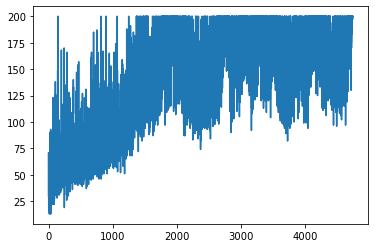

In [4]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train & verify ====')
episode_rewards = []
for episode in itertools.count():
    play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('verify episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-20:]) > 199:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()